# Frontal Detection Analysis (Landfrac analysis)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import cf_xarray as cfxr
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='10GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 nodes (10 dask workers)
cluster.scale(10)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45884 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/45884/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/45884/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:34082,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/45884/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Read in landfrac file
Already remapped from unstructured grid using `ncremap`

In [4]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'

In [5]:
topo_file = 'USGS-gtopo30_ne120np4_16xdel2-PFC-consistentSGH.regrid_0.23x0.31.nc'

In [6]:
topo_ds = xr.open_dataset(postprocessing_filepath+topo_file)
topo_ds

<xarray.Dataset>
Dimensions:       (lat: 768, lon: 1152, nbnd: 2, slat: 767, slon: 1152)
Coordinates:
  * lat           (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon           (lon) float64 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
  * slat          (slat) float64 -89.88 -89.65 -89.41 ... 89.41 89.65 89.88
  * slon          (slon) float64 0.0 0.1562 0.4688 0.7812 ... 358.9 359.2 359.5
Dimensions without coordinates: nbnd
Data variables:
    w_stag        (slat) float64 ...
    lat_bnds      (lat, nbnd) float64 ...
    lon_bnds      (lon, nbnd) float64 ...
    gw            (lat) float64 ...
    area          (lat, lon) float64 ...
    LANDFRAC      (lat, lon) float64 ...
    LANDM_COSLAT  (lat, lon) float64 ...
    PHIS          (lat, lon) float64 ...
    SGH           (lat, lon) float64 ...
    SGH30         (lat, lon) float64 ...
Attributes:
    source:          USGS 30-sec dataset binned to ncube3000 (cube-sphe
    title:           30-second USGS topo data
    history:         Tue Mar 29 15:53:58 2022: ncks -O -t 2 --no_tmp_fl --gaa...
    remap_script:    ncremap
    remap_command:   '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bin/ncremap -...
    remap_hostname:  casper-login2
    remap_version:   4.7.9
    NCO:             netCDF Operators version 4.7.9 (Homepage = http://nco.sf...
    map_file:        /glade/work/nanr/mapfiles/map_ne120_to_0.23x0.31_bilinea...
    input_file:      /glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/US...

In [7]:
landfrac_hr = topo_ds.LANDFRAC
landfrac_hr

<xarray.DataArray 'LANDFRAC' (lat: 768, lon: 1152)>
[884736 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      gridbox land fraction
    cell_measures:  area: area

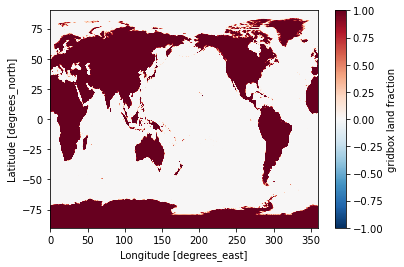

In [8]:
landfrac_hr.plot()

In [15]:
# North American domain
landfrac_hr_NA = landfrac_hr.sel(lat=slice(10,77),lon=slice(189,329))
landfrac_hr_NA

<xarray.DataArray 'LANDFRAC' (lat: 285, lon: 448)>
[127680 values with dtype=float64]
Coordinates:
  * lat      (lat) float64 10.21 10.44 10.68 10.91 ... 76.15 76.39 76.62 76.86
  * lon      (lon) float64 189.1 189.4 189.7 190.0 ... 327.8 328.1 328.4 328.8
Attributes:
    long_name:      gridbox land fraction
    cell_measures:  area: area

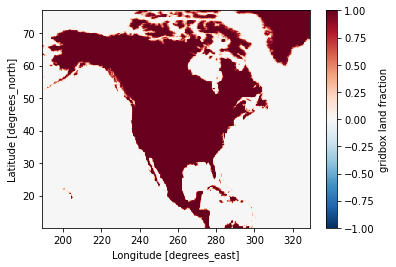

In [16]:
landfrac_hr_NA.plot()

### Read in fronts file for target resolution

In [9]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"

In [10]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/dlfront/B20TRC5CN/" # need to be on casper, CESM historical output

In [11]:
MN_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"

In [12]:
MN = xr.open_dataset(cesm_fronts_filepath+MN_file, chunks={'time':360})
MN

<xarray.Dataset>
Dimensions:     (front: 5, lat: 68, lon: 141, time: 46719)
Coordinates:
  * time        (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    front_type  (front) object dask.array<chunksize=(5,), meta=np.ndarray>
  * lon         (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat         (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
Dimensions without coordinates: front
Data variables:
    crs         float64 ...
    fronts      (time, front, lat, lon) float32 dask.array<chunksize=(360, 5, 68, 141), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.7
    institution:  North Carolina Institute for Climate Studies (NCICS)
    title:        Coded surface bulletins with masking on a custom-grid grid.
    history:      Wed Aug  4 14:55:47 2021: ncrcat CESMOutputs/cesm_fronts_20...
    NCO:          netCDF Operators version 4.9.3 (Homepage = http://nco.sf.ne...

In [14]:
fronts_MN = MN.fronts
fronts_MN

<xarray.DataArray 'fronts' (time: 46719, front: 5, lat: 68, lon: 141)>
dask.array<open_dataset-e0cbe0bfd13c883f1dee5cc5d1b0b8fefronts, shape=(46719, 5, 68, 141), dtype=float32, chunksize=(360, 5, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time        (time) object 2000-01-01 03:00:00 ... 2015-12-31 21:00:00
    front_type  (front) object dask.array<chunksize=(5,), meta=np.ndarray>
  * lon         (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat         (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 74.0 75.0 76.0 77.0
Dimensions without coordinates: front
Attributes:
    long_name:     front line images
    grid_mapping:  crs
    valid_min:     0
    valid_max:     1

### Regridding landfrac to match fronts (1deg)

In [17]:
regridder_bil = xe.Regridder(landfrac_hr_NA, fronts_MN, 'bilinear') # bilinear interpolation

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xarray/core/dataarray.py:745: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/dask/array/core.py:383: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)


In [18]:
regridder_bil

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_285x448_68x141.nc 
Reuse pre-computed weights? False 
Input grid shape:           (285, 448) 
Output grid shape:          (68, 141) 
Periodic in longitude?      False

In [19]:
landfrac_1deg_bil = regridder_bil(landfrac_hr_NA)
landfrac_1deg_bil

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.DataArray 'LANDFRAC' (lat: 68, lon: 141)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

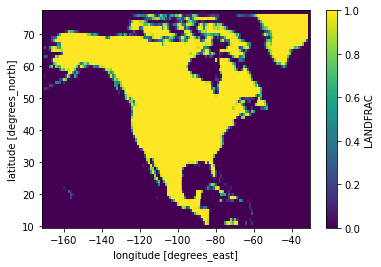

In [20]:
landfrac_1deg_bil.plot()

### Save out regridded file

In [21]:
landfrac_1deg_bil.to_netcdf(postprocessing_filepath+'landfrac_1deg_bil.nc', mode='w', format='NETCDF4')

In [22]:
client.close()
cluster.close()